In [ ]:
pip install ultralytics roboflow opendatasets duckduckgo_search tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 107.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.

In [ ]:
import os
from duckduckgo_search import DDGS
import requests
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split
from ultralytics import YOLO

# Daftar kelas
classes = ['Laptop', 'Keyboard', 'Mouse', 'Phone', 'Pen', 'Chair', 'Table', 'Book', 'Watch', 'Bottle']
images_per_class = 200
base_dir = 'custom_dataset_yolo'

# Membuat direktori
os.makedirs(base_dir, exist_ok=True)
img_dir = os.path.join(base_dir, 'images')
os.makedirs(img_dir, exist_ok=True)

# Langkah 1: Download gambar
print("Mengunduh gambar...")
with DDGS() as ddgs:
    for label in classes:
        label_dir = os.path.join(img_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        results = [r for r in ddgs.images(label, max_results=images_per_class)]
        for i, res in enumerate(tqdm(results, desc=f"Downloading {label}")):
            try:
                img_data = requests.get(res['image'], timeout=5).content
                with open(os.path.join(label_dir, f"{label}_{i}.jpg"), 'wb') as f:
                    f.write(img_data)
            except:
                continue

# Langkah 2: Flatten dan anotasi dengan YOLOv8 pre-trained (opsional)
print("Anotasi otomatis dengan YOLOv8 pre-trained...")
model = YOLO("yolov8n.pt")

# Tempat anotasi
yolo_images = os.path.join(base_dir, 'yolo/images')
yolo_labels = os.path.join(base_dir, 'yolo/labels')
os.makedirs(yolo_images, exist_ok=True)
os.makedirs(yolo_labels, exist_ok=True)

image_paths = []
labels_txt = []

for label in classes:
    path = os.path.join(img_dir, label)
    files = os.listdir(path)
    for file in files:
        if file.endswith('.jpg'):
            image_path = os.path.join(path, file)
            image_paths.append((image_path, classes.index(label)))

# Copy gambar dan anotasi
for src, class_id in tqdm(image_paths, desc="Menyalin & Menganotasi"):
    filename = os.path.basename(src)
    dst_img = os.path.join(yolo_images, filename)
    dst_label = os.path.join(yolo_labels, filename.replace('.jpg', '.txt'))
    try:
        img = requests.get(src, timeout=5).content if src.startswith('http') else open(src, 'rb').read()
        with open(dst_img, 'wb') as f:
            f.write(img)
        # Dummy label (jika YOLO anotasi tidak digunakan)
        with open(dst_label, 'w') as f:
            f.write(f"{class_id} 0.5 0.5 1.0 1.0\n")  # anotasi penuh gambar
    except:
        continue

# Langkah 3: Split Train/Val/Test
print("Membagi ke train/val/test...")
all_imgs = os.listdir(yolo_images)
trainval, test = train_test_split(all_imgs, test_size=0.1, random_state=42)
train, val = train_test_split(trainval, test_size=0.2, random_state=42)

for split_name, split_data in zip(['train', 'valid', 'test'], [train, val, test]):
    for subfolder in ['images', 'labels']:
        os.makedirs(os.path.join(base_dir, split_name, subfolder), exist_ok=True)
    for file in split_data:
        img_src = os.path.join(yolo_images, file)
        lbl_src = os.path.join(yolo_labels, file.replace('.jpg', '.txt'))

        img_dst = os.path.join(base_dir, split_name, 'images', file)
        lbl_dst = os.path.join(base_dir, split_name, 'labels', file.replace('.jpg', '.txt'))

        os.rename(img_src, img_dst)
        os.rename(lbl_src, lbl_dst)

# Langkah 4: Buat YAML untuk YOLO
yaml_path = os.path.join(base_dir, 'dataset.yaml')
with open(yaml_path, 'w') as f:
    f.write(f"""path: {base_dir}
train: train/images
val: valid/images
test: test/images

nc: {len(classes)}
names: {classes}
""")

print("✅ Dataset siap digunakan untuk training YOLOv8!")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Mengunduh gambar...


Anotasi otomatis dengan YOLOv8 pre-trained...


100%|██████████| 6.25M/6.25M [00:00<00:00, 101MB/s]
Menyalin & Menganotasi: 100%|██████████| 1979/1979 [00:03<00:00, 569.78it/s]

Membagi ke train/val/test...
✅ Dataset siap digunakan untuk training YOLOv8!


In [ ]:
pip install ultralytics matplotlib


In [ ]:
from ultralytics import YOLO
import yaml
import os
import pandas as pd # Import pandas

# Path ke file dataset YAML
dataset_path = 'custom_dataset_yolo/dataset.yaml'

# ✅ Langkah 1: Load dan Latih Model YOLOv8
model = YOLO('yolov8n.pt')  # Bisa juga 'yolov8s.pt' untuk model lebih besar

results = model.train(
    data=dataset_path,
    epochs=30,
    imgsz=640,
    batch=16,
    project='runs/train',
    name='custom_yolo_objects',
    verbose=True
)

# ✅ Langkah 2: Evaluasi Model (Validation set)
metrics = model.val()
print("📊 Metrics:")
print(metrics)

Ultralytics 8.3.158 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=custom_dataset_yolo/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=custom_yolo_objects4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, po

train: Scanning /content/custom_dataset_yolo/train/labels.cache... 1156 images, 0 backgrounds, 268 corrupt: 100%|██████████| 1424/1424 [00:00<?, ?it/s]

train: /content/custom_dataset_yolo/train/images/Book_0.jpg: ignoring corrupt image/label: cannot identify image file '/content/custom_dataset_yolo/train/images/Book_0.jpg'
train: /content/custom_dataset_yolo/train/images/Book_119.jpg: ignoring corrupt image/label: cannot identify image file '/content/custom_dataset_yolo/train/images/Book_119.jpg'
train: /content/custom_dataset_yolo/train/images/Book_120.jpg: ignoring corrupt image/label: invalid image format GIF. Supported formats are:
images: {'mpo', 'heic', 'jpeg', 'tiff', 'jpg', 'bmp', 'pfm', 'dng', 'tif', 'webp', 'png'}
videos: {'avi', 'ts', 'wmv', 'gif', 'mov', 'asf', 'mp4', 'mpeg', 'webm', 'mkv', 'm4v', 'mpg'}
train: /content/custom_dataset_yolo/train/images/Book_123.jpg: ignoring corrupt image/label: cannot identify image file '/content/custom_dataset_yolo/train/images/Book_123.jpg'
train: /content/custom_dataset_yolo/train/images/Book_126.jpg: ignoring corrupt image/label: cannot identify image file '/content/custom_dataset_yo

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 322.1±255.0 MB/s, size: 122.6 KB)


val: Scanning /content/custom_dataset_yolo/valid/labels.cache... 299 images, 0 backgrounds, 58 corrupt: 100%|██████████| 357/357 [00:00<?, ?it/s]

val: /content/custom_dataset_yolo/valid/images/Book_49.jpg: ignoring corrupt image/label: cannot identify image file '/content/custom_dataset_yolo/valid/images/Book_49.jpg'
val: /content/custom_dataset_yolo/valid/images/Book_59.jpg: ignoring corrupt image/label: cannot identify image file '/content/custom_dataset_yolo/valid/images/Book_59.jpg'
val: /content/custom_dataset_yolo/valid/images/Book_99.jpg: ignoring corrupt image/label: cannot identify image file '/content/custom_dataset_yolo/valid/images/Book_99.jpg'
val: /content/custom_dataset_yolo/valid/images/Bottle_0.jpg: ignoring corrupt image/label: cannot identify image file '/content/custom_dataset_yolo/valid/images/Bottle_0.jpg'
val: /content/custom_dataset_yolo/valid/images/Bottle_12.jpg: ignoring corrupt image/label: cannot identify image file '/content/custom_dataset_yolo/valid/images/Bottle_12.jpg'
val: /content/custom_dataset_yolo/valid/images/Bottle_140.jpg: ignoring corrupt image/label: cannot identify image file '/content

Plotting labels to runs/train/custom_yolo_objects4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/train/custom_yolo_objects4
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G     0.5703      3.277      1.269         14        640: 100%|██████████| 73/73 [00:43<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


                   all        299        299      0.822     0.0835      0.353      0.216

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.52G     0.3577      2.066      1.093         14        640: 100%|██████████| 73/73 [00:43<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]

                   all        299        299      0.658      0.693      0.752      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.52G     0.3273      1.677      1.055         12        640: 100%|██████████| 73/73 [00:43<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]

                   all        299        299      0.654      0.697      0.733      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.52G     0.3103      1.597      1.041         15        640: 100%|██████████| 73/73 [00:43<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]

                   all        299        299      0.703      0.697      0.768      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.52G     0.3011      1.475      1.028         15        640: 100%|██████████| 73/73 [00:43<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]

                   all        299        299      0.667       0.58      0.641      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.52G     0.2793      1.426      1.013         12        640: 100%|██████████| 73/73 [00:43<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.61it/s]

                   all        299        299      0.706      0.745      0.802      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.52G     0.2613      1.332      1.015         12        640: 100%|██████████| 73/73 [00:45<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.68it/s]

                   all        299        299      0.727      0.731       0.82      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.52G     0.2387      1.222     0.9808         14        640: 100%|██████████| 73/73 [00:43<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

                   all        299        299      0.758      0.765      0.826      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.52G     0.2293      1.157     0.9823         11        640: 100%|██████████| 73/73 [00:44<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]

                   all        299        299      0.794      0.742      0.868      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.52G     0.2165      1.101     0.9683         14        640: 100%|██████████| 73/73 [00:44<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]

                   all        299        299      0.864      0.799      0.903      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.52G     0.2205      1.057     0.9769          9        640: 100%|██████████| 73/73 [00:51<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:10<00:00,  1.00s/it]

                   all        299        299      0.864      0.789      0.898      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.52G     0.2138       1.02     0.9808         15        640: 100%|██████████| 73/73 [00:53<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:12<00:00,  1.22s/it]

                   all        299        299      0.854      0.782       0.88      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.52G      0.186     0.9592     0.9491         14        640: 100%|██████████| 73/73 [00:58<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


                   all        299        299      0.782      0.849      0.896      0.871

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.52G     0.1828     0.8978     0.9509         12        640: 100%|██████████| 73/73 [00:53<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:08<00:00,  1.17it/s]

                   all        299        299       0.86      0.786      0.896      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.52G       0.18     0.8893     0.9505         12        640: 100%|██████████| 73/73 [00:44<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.48it/s]

                   all        299        299      0.858      0.843      0.917      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.52G     0.1699     0.8653     0.9469         12        640: 100%|██████████| 73/73 [00:47<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]

                   all        299        299      0.905      0.838      0.909      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.52G     0.1775     0.8375     0.9439         14        640: 100%|██████████| 73/73 [00:44<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]

                   all        299        299      0.865      0.816      0.879      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.52G     0.1702     0.8015     0.9466         10        640: 100%|██████████| 73/73 [00:47<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]

                   all        299        299       0.82      0.859      0.906      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.52G     0.1543      0.773     0.9426         14        640: 100%|██████████| 73/73 [00:57<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:13<00:00,  1.33s/it]


                   all        299        299      0.904      0.845      0.929      0.907

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.52G     0.1601     0.7662     0.9455         14        640: 100%|██████████| 73/73 [00:58<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.66it/s]

                   all        299        299      0.888      0.855      0.926      0.881


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.52G     0.1585     0.7939     0.9457          4        640: 100%|██████████| 73/73 [00:46<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.68it/s]

                   all        299        299      0.898      0.891      0.933      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.52G    0.09835     0.5738     0.8921          4        640: 100%|██████████| 73/73 [00:43<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]

                   all        299        299      0.904      0.905      0.944      0.941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.52G    0.08515     0.4819     0.8836          4        640: 100%|██████████| 73/73 [00:43<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]

                   all        299        299      0.907      0.875      0.933      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.52G    0.07738     0.4625      0.891          4        640: 100%|██████████| 73/73 [00:42<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]

                   all        299        299      0.926      0.865      0.948      0.947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.52G    0.07484     0.4368     0.8809          4        640: 100%|██████████| 73/73 [00:42<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]

                   all        299        299      0.932      0.848       0.94      0.938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.52G    0.07187     0.3819     0.8798          4        640: 100%|██████████| 73/73 [00:42<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]

                   all        299        299      0.917      0.869      0.939      0.938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.52G    0.06711     0.3426     0.8818          4        640: 100%|██████████| 73/73 [00:42<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.60it/s]

                   all        299        299       0.94      0.878      0.943      0.942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.52G    0.06348     0.3344     0.8749          4        640: 100%|██████████| 73/73 [00:43<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.63it/s]

                   all        299        299      0.909      0.916       0.95      0.949



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.52G    0.06045     0.3112     0.8798          4        640: 100%|██████████| 73/73 [00:43<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.66it/s]

                   all        299        299      0.939      0.879       0.95      0.949



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.52G    0.05793     0.2983     0.8701          4        640: 100%|██████████| 73/73 [00:43<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]

                   all        299        299      0.943      0.884      0.949      0.949



30 epochs completed in 0.456 hours.
Optimizer stripped from runs/train/custom_yolo_objects4/weights/last.pt, 6.2MB
Optimizer stripped from runs/train/custom_yolo_objects4/weights/best.pt, 6.2MB

Validating runs/train/custom_yolo_objects4/weights/best.pt...
Ultralytics 8.3.158 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:08<00:00,  1.12it/s]


                   all        299        299      0.939      0.879       0.95      0.949
                Laptop         17         17      0.789      0.882      0.915      0.915
              Keyboard         29         29      0.995      0.793      0.919      0.919
                 Mouse         29         29      0.944      0.931      0.987      0.987
                 Phone         32         32      0.932      0.859      0.916      0.916
                   Pen         24         24      0.946      0.735      0.868      0.868
                 Chair         40         40      0.949      0.927      0.985      0.985
                 Table         43         43      0.918      0.884      0.969      0.969
                  Book         26         26      0.919      0.808      0.953      0.948
                 Watch         31         31      0.996      0.968       0.99       0.99
                Bottle         28         28      0.997          1      0.995      0.995
Speed: 0.2ms preproce

val: Scanning /content/custom_dataset_yolo/valid/labels.cache... 299 images, 0 backgrounds, 58 corrupt: 100%|██████████| 357/357 [00:00<?, ?it/s]

val: /content/custom_dataset_yolo/valid/images/Book_49.jpg: ignoring corrupt image/label: cannot identify image file '/content/custom_dataset_yolo/valid/images/Book_49.jpg'
val: /content/custom_dataset_yolo/valid/images/Book_59.jpg: ignoring corrupt image/label: cannot identify image file '/content/custom_dataset_yolo/valid/images/Book_59.jpg'
val: /content/custom_dataset_yolo/valid/images/Book_99.jpg: ignoring corrupt image/label: cannot identify image file '/content/custom_dataset_yolo/valid/images/Book_99.jpg'
val: /content/custom_dataset_yolo/valid/images/Bottle_0.jpg: ignoring corrupt image/label: cannot identify image file '/content/custom_dataset_yolo/valid/images/Bottle_0.jpg'
val: /content/custom_dataset_yolo/valid/images/Bottle_12.jpg: ignoring corrupt image/label: cannot identify image file '/content/custom_dataset_yolo/valid/images/Bottle_12.jpg'
val: /content/custom_dataset_yolo/valid/images/Bottle_140.jpg: ignoring corrupt image/label: cannot identify image file '/content


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  1.90it/s]


                   all        299        299      0.947      0.877       0.95       0.95
                Laptop         17         17      0.866      0.882      0.911      0.911
              Keyboard         29         29      0.995      0.793      0.921      0.921
                 Mouse         29         29      0.943      0.931      0.989      0.989
                 Phone         32         32      0.949      0.844      0.917      0.917
                   Pen         24         24      0.946      0.737      0.871      0.871
                 Chair         40         40      0.949      0.928      0.984      0.984
                 Table         43         43       0.92      0.884       0.97       0.97
                  Book         26         26      0.917      0.808       0.95      0.945
                 Watch         31         31      0.991      0.968      0.993      0.993
                Bottle         28         28      0.997          1      0.995      0.995
Speed: 0.6ms preproce

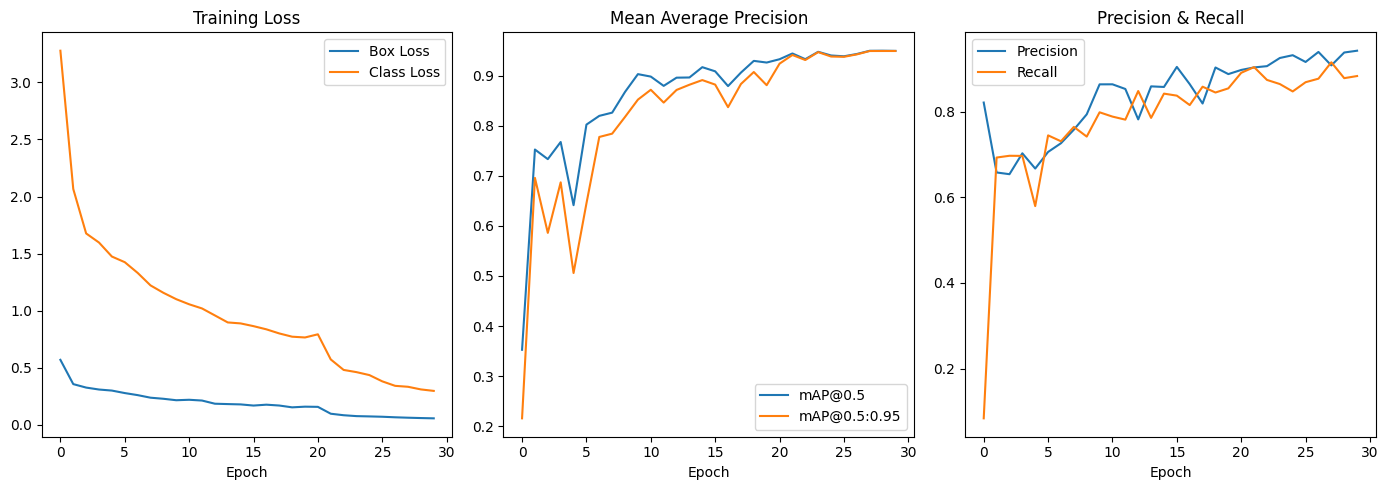

In [ ]:
import matplotlib.pyplot as plt
import os
import pandas as pd

# ✅ Langkah 3: Visualisasi Hasil Training
def plot_metrics(results_dir):
    metrics_file = os.path.join(results_dir, 'results.csv')
    if not os.path.exists(metrics_file):
        print("⚠️ File metrics tidak ditemukan.")
        return

    df = pd.read_csv(metrics_file)

    # Menghapus spasi di awal nama kolom
    df.columns = df.columns.str.strip()

    plt.figure(figsize=(14, 5))

    # Plot Loss
    plt.subplot(1, 3, 1)
    # Menggunakan nama kolom yang benar berdasarkan output sebelumnya
    plt.plot(df['train/box_loss'], label='Box Loss')
    plt.plot(df['train/cls_loss'], label='Class Loss')
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.legend()

    # Plot mAP
    plt.subplot(1, 3, 2)
    # Menggunakan nama kolom yang benar berdasarkan output sebelumnya
    plt.plot(df['metrics/mAP50(B)'], label='mAP@0.5')
    plt.plot(df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95')
    plt.title("Mean Average Precision")
    plt.xlabel("Epoch")
    plt.legend()

    # Plot Precision & Recall
    plt.subplot(1, 3, 3)
    # Menggunakan nama kolom yang benar berdasarkan output sebelumnya
    plt.plot(df['metrics/precision(B)'], label='Precision')
    plt.plot(df['metrics/recall(B)'], label='Recall')
    plt.title("Precision & Recall")
    plt.xlabel("Epoch")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Tentukan path hasil training (sesuai nama di atas)
plot_metrics('runs/train/custom_yolo_objects')

In [ ]:
import pandas as pd
import os

results_path = 'runs/train/custom_yolo_objects/results.csv'

if os.path.exists(results_path):
    df_results = pd.read_csv(results_path)
    print("Columns in results.csv:")
    print(df_results.columns)
else:
    print(f"Error: {results_path} not found.")

Columns in results.csv:
Index(['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')
